In [1]:
from typing import Callable
from pprint import pprint
# all additional modules are listed in requirements.txt
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib widget needs ipyml, remove if you don't have it
%matplotlib widget
sp.__version__, np.__version__, matplotlib.__version__

('1.12', '1.24.3', '3.7.2')

In [49]:
# variant M
mat_len = 20
a = np.zeros((mat_len,mat_len))
for i in range(len(a)):
    a[i][i] = 10 # c_i
    if i+1 < len(a):
        a[i][i+1] = 1 # d_i
        a[i+1][i] = 1 # b_i
    if i+2 < len(a):
        a[i][i+2] = 0.1 # e_i
        a[i+2][i] = 0.1 # a_i

f = np.arange(1, mat_len + 1, dtype=float)

sp.Matrix(a), sp.Matrix(f) # for cute print

(Matrix([
 [10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [ 1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [ 0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0,  0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0,    0,  0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0,    0,    0,  0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0,    0,    0,    0,  0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0,    0,    0,    0,    0,  0.1,  1.0, 10.0,  1.0,  0.1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
 [   0

## Gauss

In [3]:
def gauss_to_upper(a: np.ndarray, f: np.ndarray):
    a = a.copy()
    f = f.copy()
    if len(a.shape) != 2 or len(a) != len(f) or a.shape[0] != a.shape[1]:
        raise ValueError(f"Wrong dimensions! {f.shape=} and {a.shape=} were provided")
    for cur_col in range(len((a))):
        max_row = a[cur_col:, cur_col].argmax() + cur_col
        a[[cur_col, max_row]] = a[[max_row, cur_col]] # swap
        f[[cur_col, max_row]] = f[[max_row, cur_col]]
        for i in range(cur_col+1, len(a)):
            coeff = a[i, cur_col] / a[cur_col, cur_col]
            a[i, :] -= a[cur_col, :] * coeff
            f[i] -= f[cur_col] * coeff
    return a, f

In [4]:
def solve_upper(a: np.ndarray, f: np.ndarray):
    if len(a.shape) != 2 or len(a) != len(f) or a.shape[0] != a.shape[1]:
        raise ValueError(f"Wrong dimensions! {f.shape=} and {a.shape=} were provided")
    x = np.zeros(len(a))
    for cur_col in range(len(a)-1, -1, -1):
        x[cur_col] = (f[cur_col] - np.dot(a[cur_col], x)) / a[cur_col, cur_col]
    return x

In [43]:
a_up, f_up = gauss_to_upper(a, f)
x = solve_upper(a_up, f_up)
residual = sum((np.dot(a, x) - f)**2)**0.5
f"Gauss method {residual=}"

'Gauss method residual=4.48508116795402e-15'

## LU

In [7]:
def lu_decomposition(a: np.ndarray):
    u = np.zeros(a.shape)
    l = np.zeros(a.shape)
    np.fill_diagonal(l, 1)
    for i in range(len(a)):
        for j in range(len(a)):
            if i <= j:
                u[i][j] = a[i][j] - np.dot(l[i, :i+1], u[:i+1, j])
            if i > j:
                l[i][j] = (a[i][j] - np.dot(l[i, :j+1], u[:j+1, j])) / u[j][j]
    return l, u

In [19]:
def solve_lower(a: np.ndarray, f: np.ndarray):
    x = np.zeros(len(a))
    for cur_col in range(len(a)):
        x[cur_col] = (f[cur_col] - np.dot(a[cur_col], x)) / a[cur_col, cur_col]
    return x

In [21]:
def solve_lu(a: np.ndarray, f: np.ndarray):
    l, u = lu_decomposition(a)
    y = solve_lower(l, f)
    return solve_upper(u, y)

In [44]:
x = solve_lu(a, f)
residual = sum((np.dot(a, x) - f)**2)**0.5
f"LU decomposition {residual=}"

'LU decomposition residual=4.468561475845092e-15'

# Iterations

In [10]:
def run_iter(a: np.ndarray, f: np.ndarray, iteration: Callable, x=None, iterations=10):
    if x is None:
        x = np.zeros(len(a))
    xs = []
    for i in range(iterations):
        x = iteration(a, f, x)
        xs.append(x)
    return xs

In [11]:
def seidel_iter(a: np.ndarray, f: np.ndarray, x: np.ndarray):
    x_new = np.copy(x)
    for i in range(len(a)):
        s1 = sum(a[i][j] * x_new[j] for j in range(i))
        s2 = sum(a[i][j] * x[j] for j in range(i + 1, len(a)))
        x_new[i] = (f[i] - s1 - s2) / a[i][i]
    return x_new

In [12]:
def jacobi_iter(a: np.ndarray, f: np.ndarray, x: np.ndarray):
    return np.diag(a)**(-1) * (f - np.dot(np.tril(a) + np.triu(a), x))

In [13]:
def relaxation_iter(a: np.ndarray, f: np.ndarray, x: np.ndarray, w=1):
    x_new = np.zeros(len(x))
    for k in range(len(x)):
        x_new[k] = x[k] + w/a[k][k] * (f[k] - np.dot(a[k], x))
    return x_new

In [40]:
def plot_res(res, title=''):
    def prep_ax(title=''):
        fig, ax = plt.subplots(figsize=(8,5))
        # ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        ax.grid(True)
        ax.grid(True, 'minor', ls=':')
        ax.set_xlabel('iteration')
        ax.set_ylabel('residual')
        ax.set_title(title)
        return fig, ax

    fig, ax = prep_ax(title)
    ax.plot([sum((np.dot(a, res[i]) - f)**2)**0.5 for i in range(len(res))], '-o')

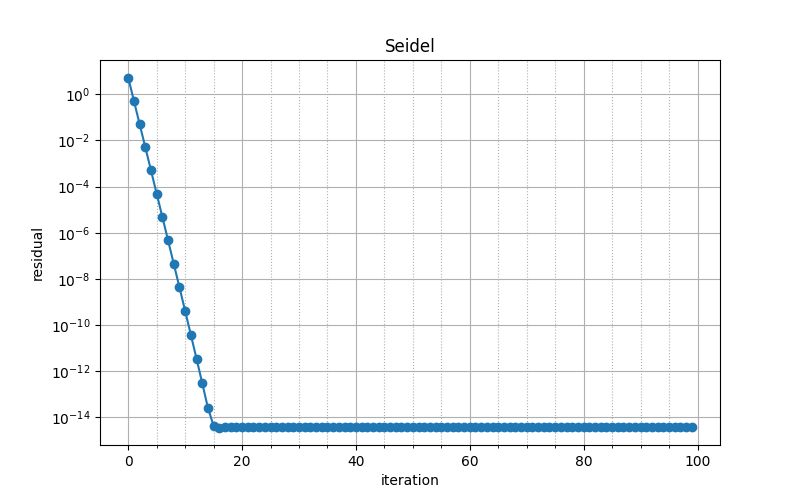

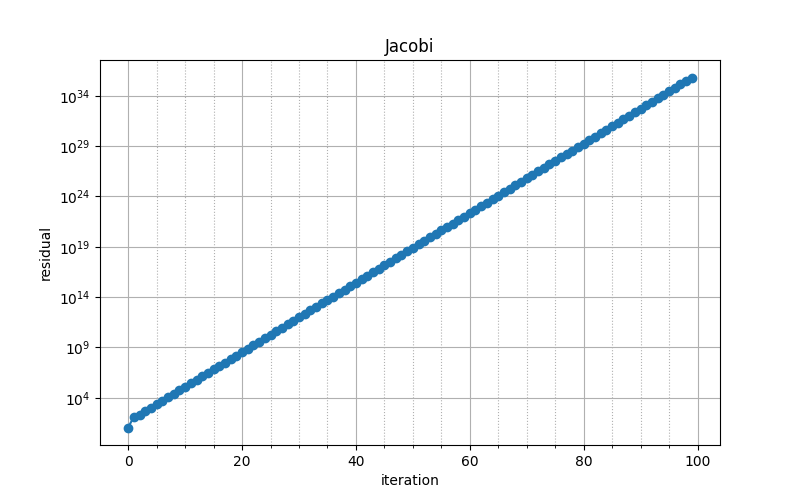

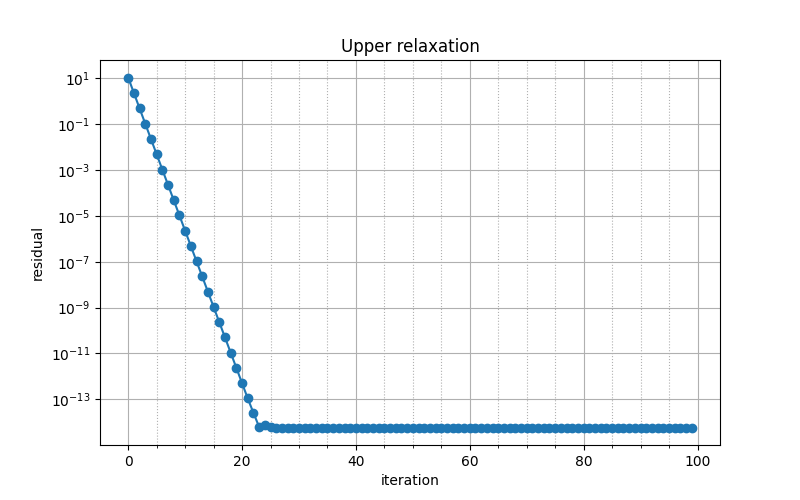

In [42]:
res = run_iter(a, f, seidel_iter, iterations=100)
plot_res(res, 'Seidel')

res = run_iter(a, f, jacobi_iter, iterations=100)
plot_res(res, 'Jacobi')

res = run_iter(a, f, relaxation_iter, iterations=100)
plot_res(res, 'Upper relaxation')